In [1]:
from brian2 import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- Parameters ---
N       = 10000  #number of neurons
K       = 1000  #connectivity - each neuron connected to K different neurons

V_T     = 1.0 # voltage threshold
V_R     = 0.0 # voltage reset

nu      = 10*Hz #firing rate
J_0     = 1.0 
tau_m   = 10*ms #membrane time constant

I_0 = nu * J_0 * tau_m 
Iext_const = np.sqrt(K) * I_0 #constant excitatory current
w_inh = J_0/np.sqrt(K) # inhibitory input received

In [3]:
# alter the function slightly to only output the endvector (for lower runtime)

def run_start_end(runtime, startvector):   #enter the runtime in seconds but with the unit
    
    start_scope() 
    defaultclock.dt = 0.1*ms

    # makes use of all variables declared globally, i.e. V_f, V_t, nu, N, K...

    # --- Neuronmodell (Voltage-LIF) ---
    # tau_m dV/dt = -V + I(t) (1), with I(t)=sqrt(K)*I_0 - (J_0/sqrt(K))*sum delta(...)
    eqs = """
    dV/dt = (-V + I_ext)/tau_m : 1  #dimensionless
    I_ext : 1                       #dimensionless constant excitatory current
    """

    G = NeuronGroup(
        N,
        model=eqs,
        threshold="V >= V_T",
        reset="V = V_R",
        method="euler"
    )

    # Initialisierung
    G.V = startvector   #initialize voltage values to start vector
    G.I_ext = Iext_const   #initialize excitatory current with global value

    #connectivity probability
    p = K / (N-1)   # p in (0,1)

    seed(2)           # Brian2 seed
    S = Synapses(G, G, on_pre="V -= w_inh")  # when action potential occurs, decrease the voltage of post-synaptic neuron
    S.connect(condition='i!=j', p=p) # set recurrent connections with probability p, set all self recurrent connections to 0


    #sp_mon = SpikeMonitor(G)
    # mon_all_V = StateMonitor(G, 'V', record=True) #((len(indices), len(t)))
    # popmon = PopulationRateMonitor(G)
    #print(f"\nRunning simulation for T = {runtime}")

    run(runtime)
    mon_endvalues = np.array(G.V) #takes only final voltages

    return mon_endvalues #, mon_all_V, popmon

In [4]:
#starting from the center of a fluxtube

initial_randvector = np.random.rand(N)
#print(initial_randvector)

# V_0, trajectory, popmon = run_start_end(1*second, initial_randvector)
V_0 = run_start_end(0.5*second, initial_randvector)
print(V_0)

# plt.plot(trajectory.t , trajectory.V[0])
# plt.show()
# plt.plot(popmon.t , popmon.smooth_rate(width=0.5*ms))

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


[0.52956894 0.47388893 0.28909692 ... 0.36112753 0.54892835 0.79344605]


In [32]:
# Creating the two normalized random vectors p and q and adding them to the center of a fluxtube

p_vec = np.random.normal(0,1,N)
p_vec /= np.linalg.norm(p_vec)

q_vec = np.random.normal(0,1,N)
q_vec /= np.linalg.norm(q_vec)

# put this into a 20x20 matrix
Vij = np.zeros((20,20,N))

for a in range(0,20):
    for b in range(0,20):
        Vij[a,b] = (-0.001 + a * 0.0001) * p_vec + (-0.001 + b * 0.0001) * q_vec + V_0


In [40]:
# run this for the 400 conditions
runtime = 10*ms

# create a matrix to store the resulting end vectors
# add a dimension of 1 to add the flux tube group later
end_matrix = np.zeros((20,20,1,N))


for a in range(19,20):
    for b in range(19,20):
        end_matrix[a,b,0] = run_start_end(runtime, Vij[a,b])


In [41]:
end_matrix[19,19,0]
#[0.62106411, 0.51349036, 0.08041475, ..., 0.10823177, 0.79704109,
       #0.57026998], shape=(10000,))

array([0.4452124 , 0.58389186, 0.30756883, ..., 0.56993497, 0.53457841,
       0.48876301], shape=(10000,))

What follows is just code to try to debug the error that we have in the code.

In [269]:
# Look at the euclidean difference and what a good divergence vs. convergence criterium is

# alter the function slightly to only output the endvector (for lower runtime)

def run_trajectory(runtime, startvector, frequency):   #enter the runtime in seconds but with the unit
    
    start_scope() 
    defaultclock.dt = 0.1*ms

        # --- Parameters ---
    N       = 200  #number of neurons
    K       = 100  #connectivity - each neuron connected to K different neurons

    V_T     = 1.0 # voltage threshold
    V_R     = 0.0 # voltage reset

    nu      = frequency*Hz #firing rate
    J_0     = 1.0 
    tau_m   = 10*ms #membrane time constant

    I_0 = nu * J_0 * tau_m 
    Iext_const = np.sqrt(K) * I_0 #constant excitatory current
    w_inh = J_0/np.sqrt(K) # inhibitory input received

    # makes use of all variables declared globally, i.e. V_f, V_t, nu, N, K...

    # --- Neuronmodell (Voltage-LIF) ---
    # tau_m dV/dt = -V + I(t) (1), with I(t)=sqrt(K)*I_0 - (J_0/sqrt(K))*sum delta(...)
    eqs = """
    dV/dt = (-V + I_ext)/tau_m : 1  #dimensionless
    I_ext : 1                       #dimensionless constant excitatory current
    """

    G = NeuronGroup(
        N,
        model=eqs,
        threshold="V >= V_T",
        reset="V = V_R",
        method="euler"
    )

    # Initialisierung
    G.V = startvector   #initialize voltage values to start vector
    G.I_ext = Iext_const   #initialize excitatory current with global value

    #connectivity probability
    p = K / (N-1)   # p in (0,1)

    seed(2)           # Brian2 seed
    S = Synapses(G, G, on_pre="V -= w_inh")  # when action potential occurs, decrease the voltage of post-synaptic neuron
    S.connect(condition='i!=j', p=p) # set recurrent connections with probability p, set all self recurrent connections to 0


    #sp_mon = SpikeMonitor(G)
    mon_all_V = StateMonitor(G, 'V', record=True) #((len(indices), len(t)))
    #popmon = PopulationRateMonitor(G)
    #print(f"\nRunning simulation for T = {runtime}")

    run(runtime)
    #mon_endvalues = np.array(G.V) #takes only final voltages

    return mon_all_V #, mon_endvalues,  popmon

def T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const):
    '''a constant value needed for voltage to phase space transition
    '''
    ln = np.log((VT-I_ext)/(VR-Iext_const))
    return -tau * ln

def phi(V):
    '''
    takes unitless Voltage value, returns phi space
    '''
    Tfree = T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const)
    return - tau_m / Tfree *(np.log((V-Iext_const)/(V_R-Iext_const)))

def phi_inv(phi, C = Iext_const, tau_m = tau_m):
    '''Converts from phi space from voltage space
    '''
    Tfree = T_free(tau = tau_m, VT=V_T, VR=V_R, I_ext=Iext_const)/ms
    exponent = - phi * Tfree / (tau_m/ms)
    return (V_R - C) * np.exp(exponent) + C


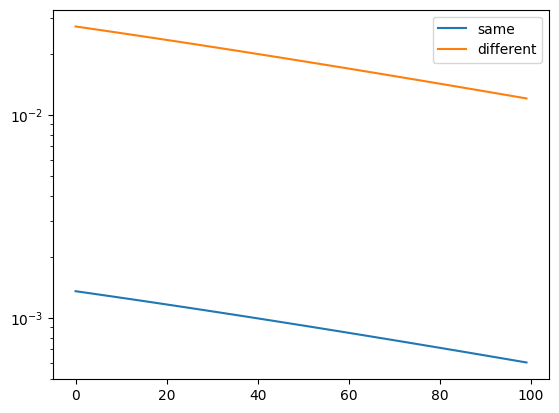

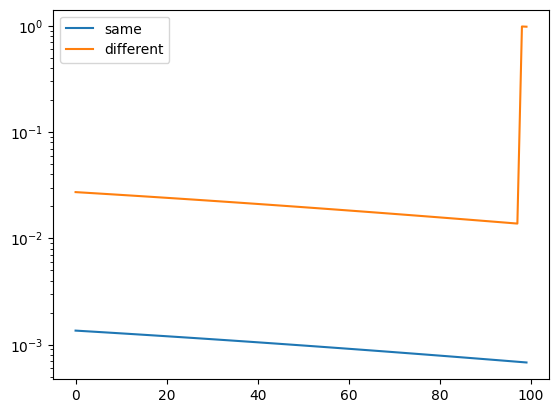

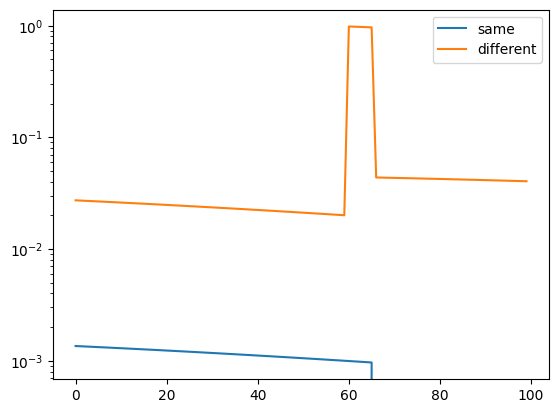

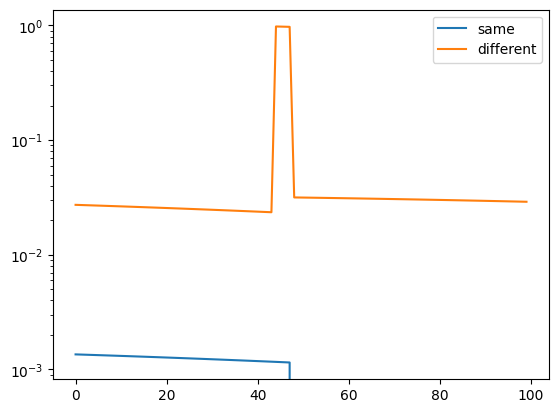

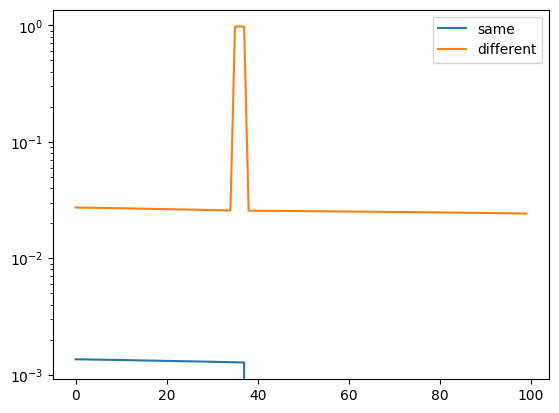

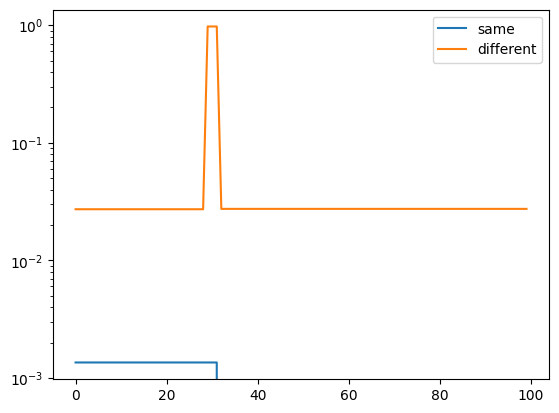

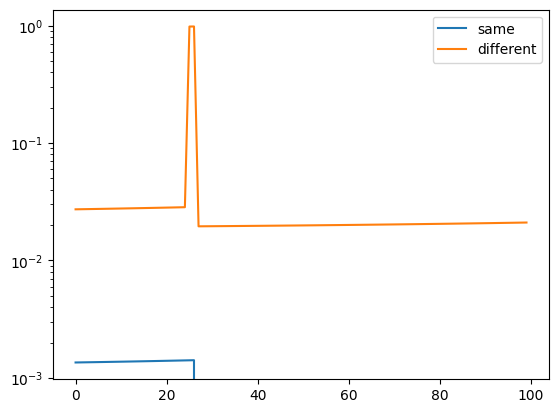

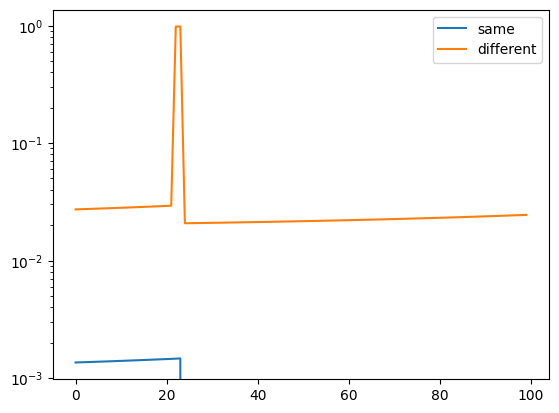

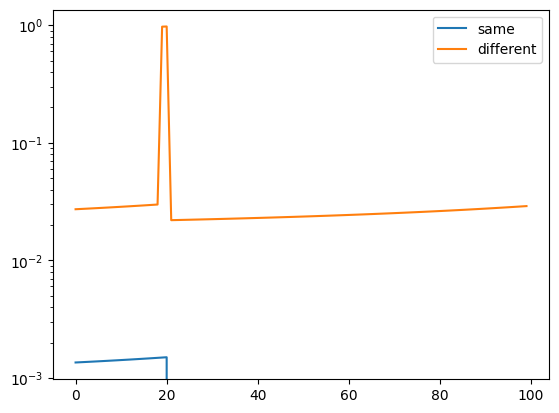

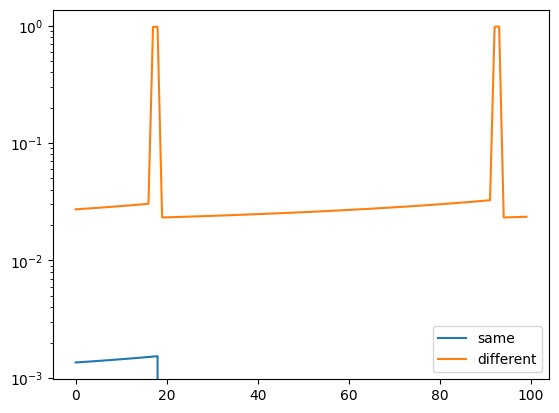

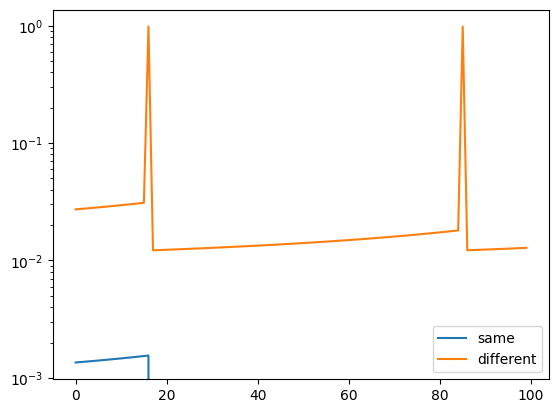

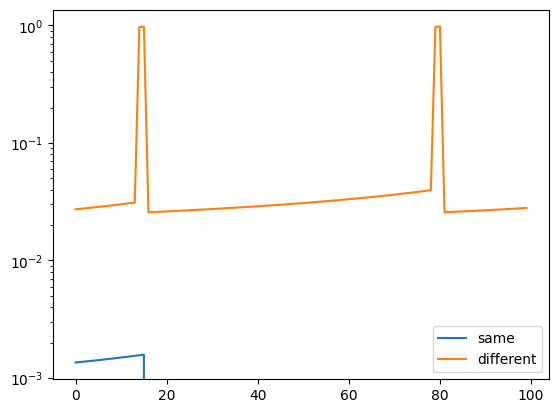

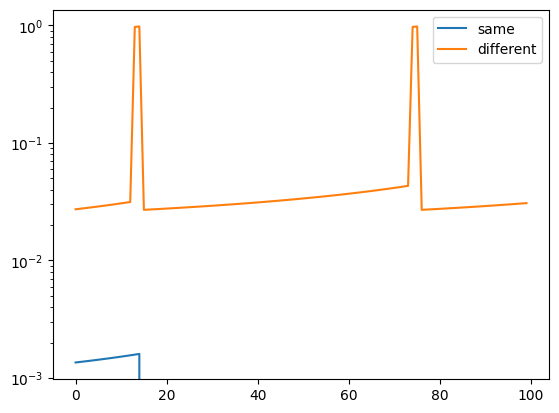

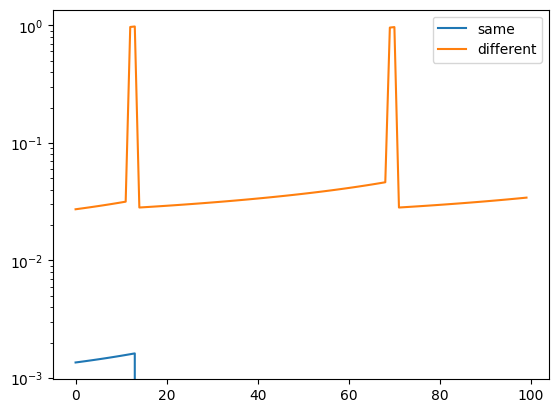

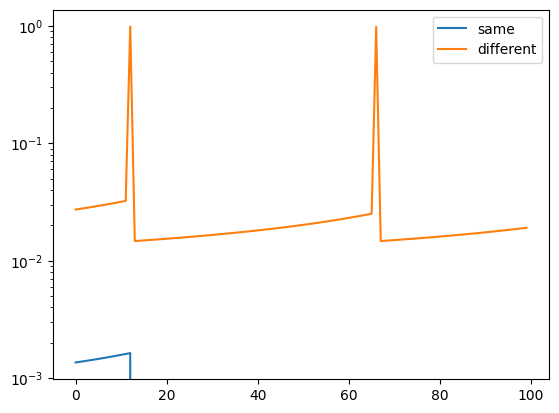

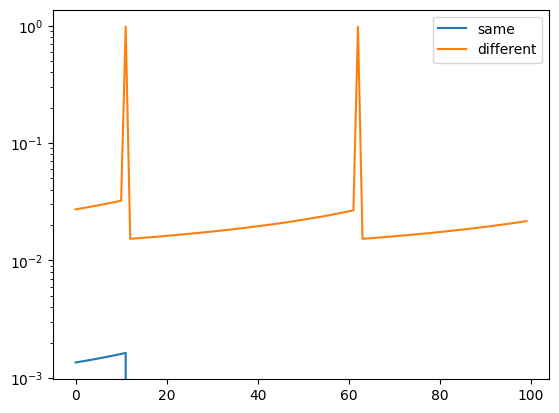

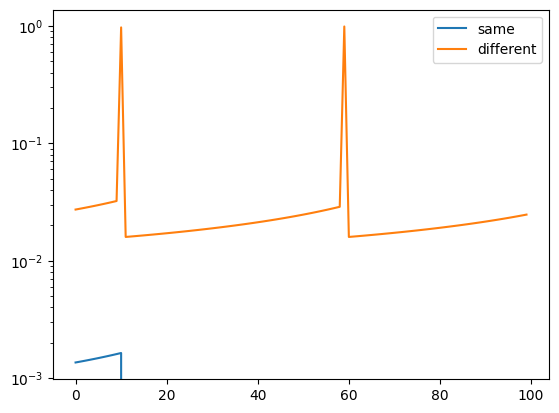

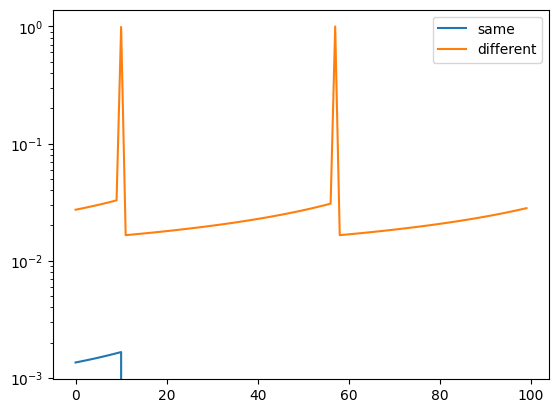

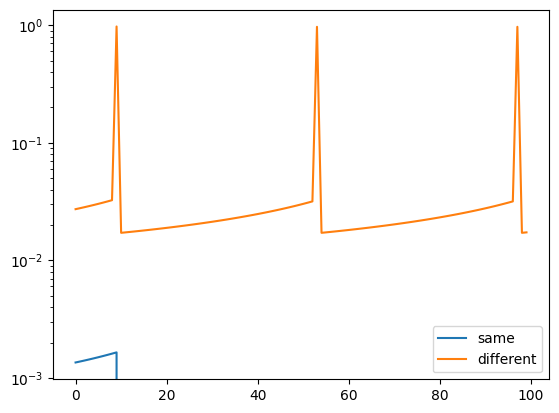

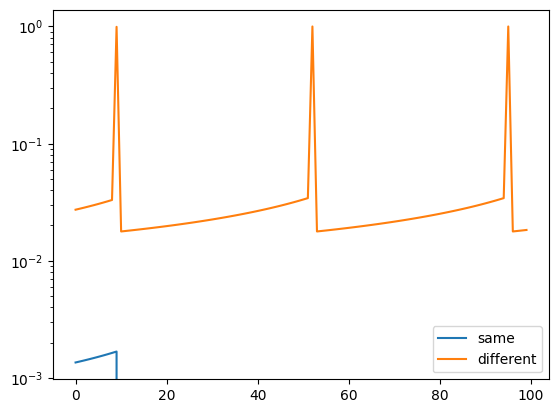

In [270]:
# see the difference in trajectories 
for i in range(10,30):
    #nu      = i*Hz #firing rate


    traj1 = run_trajectory(runtime, Vij[0,19,0], i)
    traj2 = run_trajectory(runtime, Vij[1,19,0], i)

    #convert to phase space
    traj1p = phi(traj1.V)
    traj2p = phi(traj2.V)

    diff_trajectories = np.abs(traj1p - traj2p)
    #print(diff_trajectories)
    #diff_trajectories.shape

    diff_trajectories_normalized = diff_trajectories.sum(axis=0) / N

    plt.plot(diff_trajectories_normalized, label='same')
    plt.yscale('log')

    # do the same for different trajectories
    traj3 = run_trajectory(runtime, Vij[19,0,0], i)
    traj3p = phi(traj3.V)
    diff_trajectories_other = np.abs(traj1p - traj3p)
    diff_trajectories_other_normalized = diff_trajectories_other.sum(axis=0) / N

    plt.plot(diff_trajectories_other_normalized, label='different')
    plt.legend()
    plt.show()

    #diff_trajectories_other_normalized